In [2]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import torch
import pytorch_lightning as pl
import librosa
import pandas as pd
import variables as v
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt



In [24]:
_ROOT = Path('..')
output = Path('..') / Path('output')
sr = 16000
_root = v.CCS_Root
roots = [v.CCS_Root, v.PRIMATES_Root]
ext = 'png'


In [23]:
def print_stats(data_option, mean_duration, std_duration, min_duration, max_duration):
    print(f'For {data_option}; statistics are:')
    print(f'Mean duration: {mean_duration:.3f}s\tstd: {std_duration:.3f}s '
          f'min: {min_duration:.3f}s\t max: {max_duration:.3f}s')

def show_and_save(data_option, title):
    plt.tight_layout()
    figure = plt.gcf()
    plt.show()
    figure.savefig(f'figures/{data_option}_{title.lower().replace(" ", "_")}.{ext}', format=ext, )

In [5]:
data = defaultdict(dict)
for root in roots:
    for data_option in ['train', 'devel', 'test']:
        lab_csv = pd.read_csv(root / 'lab' / f'{data_option}.csv')
        labels = []
        durations = []
        durations_per_class = defaultdict(list)
        for idx, row in lab_csv.iterrows():
            duration = librosa.get_duration(filename=str(root / 'wav' / row.filename), sr=sr)
            durations.append(duration)
            labels.append(row.label)
            durations_per_class[row.label].append(duration)
        durations_per_class = dict(durations_per_class)
        data[f'{root.name}_{data_option}'].update(durations=durations, labels=labels, durations_per_class=durations_per_class)

data = dict(data)

In [43]:
for data_option in data.keys():
    # For all files in data_option
    durations = data[data_option]['durations']
    print_stats(data_option, np.mean(durations), np.std(durations), np.min(durations), np.max(durations))

    # Per class in data_option
    durations_per_class = data[data_option]['durations_per_class']
    for label in durations_per_class.keys():
        cls_dur = durations_per_class[label]
        print_stats(label, np.mean(cls_dur), np.std(cls_dur), np.min(cls_dur), np.max(cls_dur))
    print('----------------------######################-----------------\n')

For train; statistics are:
Mean duration: 6.472s	std: 2.202s min: 2.480s	 max: 17.067s
For negative; statistics are:
Mean duration: 6.296s	std: 2.235s min: 2.480s	 max: 17.067s
For positive; statistics are:
Mean duration: 7.003s	std: 2.007s min: 3.480s	 max: 11.640s
----------------------######################-----------------

For devel; statistics are:
Mean duration: 6.096s	std: 2.262s min: 2.040s	 max: 16.115s
For positive; statistics are:
Mean duration: 6.429s	std: 2.186s min: 2.159s	 max: 11.760s
For negative; statistics are:
Mean duration: 6.009s	std: 2.274s min: 2.040s	 max: 16.115s
----------------------######################-----------------

For test; statistics are:
Mean duration: 6.441s	std: 2.340s min: 1.560s	 max: 16.161s
For ?; statistics are:
Mean duration: 6.441s	std: 2.340s min: 1.560s	 max: 16.161s
----------------------######################-----------------



In [8]:
plt.style.use('default')
sns.set_palette('Dark2')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

# plt.rcParams.update(tex_fonts)

Path('figures').mkdir(exist_ok=True)

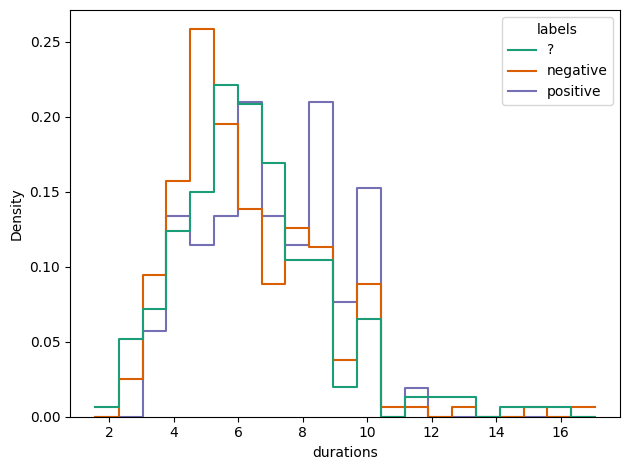

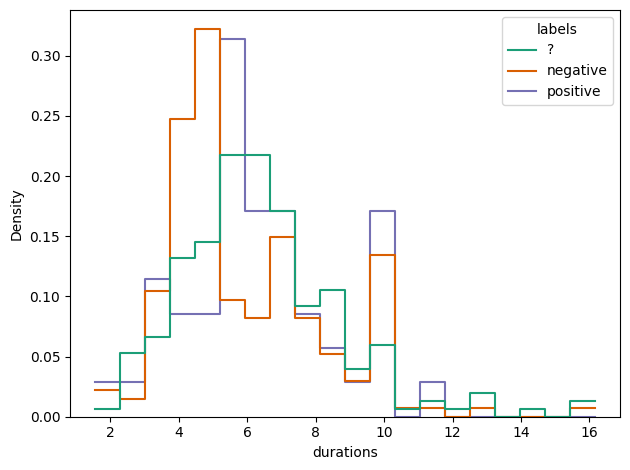

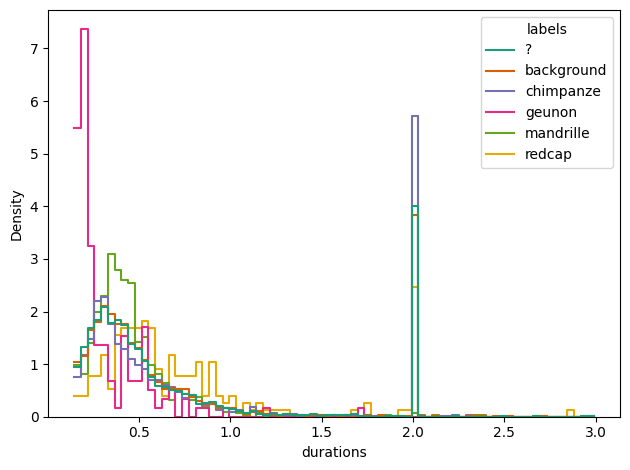

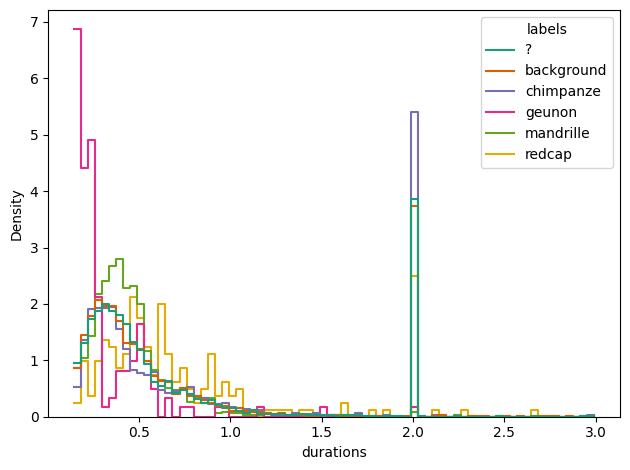

In [27]:
for root in roots:
    for data_option in ['train', 'devel']:
        title = 'durations per class'
        key = f'{root.name}_{data_option}'
        test_key = f'{root.name}_test'

        # Create the pandas DataFrame
        df = pd.DataFrame().from_dict({key:val for key, val in data[key].items() if key!='durations_per_class'})
        df_test = pd.DataFrame().from_dict({key:val for key, val in data[test_key].items() if key!='durations_per_class'})
        df = df.append(df_test)

        # Plotting
        histplot = sns.histplot(
            data=df, x="durations", hue="labels",
            hue_order=sorted((*data[key]['durations_per_class'].keys(), '?')),
            log_scale=False, element="step", fill=False, bins='auto',
            cumulative=False, stat="density", common_norm=False,
        )
        #histplot.set(title=f'{data_option}-dataset {title}')

        show_and_save(data_option, title)

          durations
labels             
negative        215
positive         71
          durations
labels             
negative        183
positive         48
        durations
labels           
?             208
            durations
labels               
background       3458
chimpanze        2217
geunon            158
mandrille         874
redcap            208
            durations
labels               
background       3459
chimpanze        2217
geunon            159
mandrille         874
redcap            209
        durations
labels           
?            6923


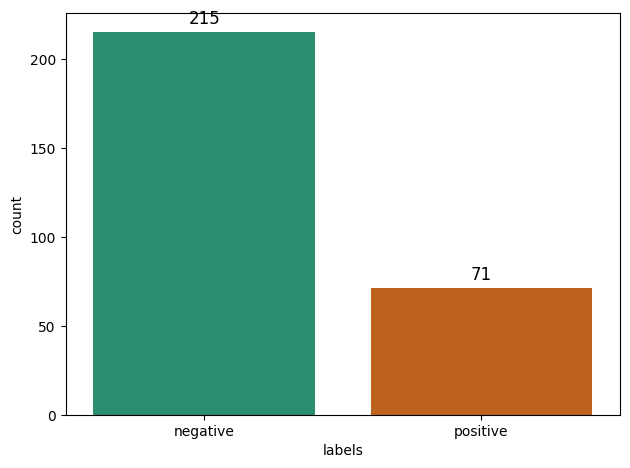

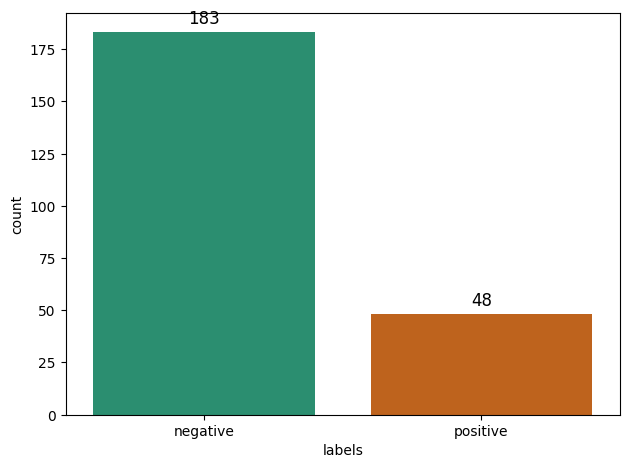

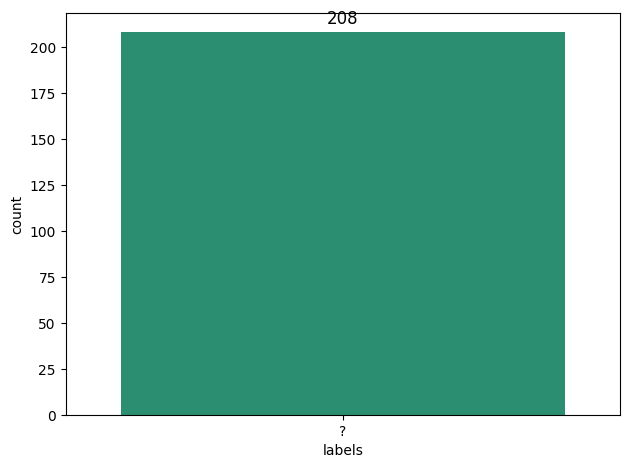

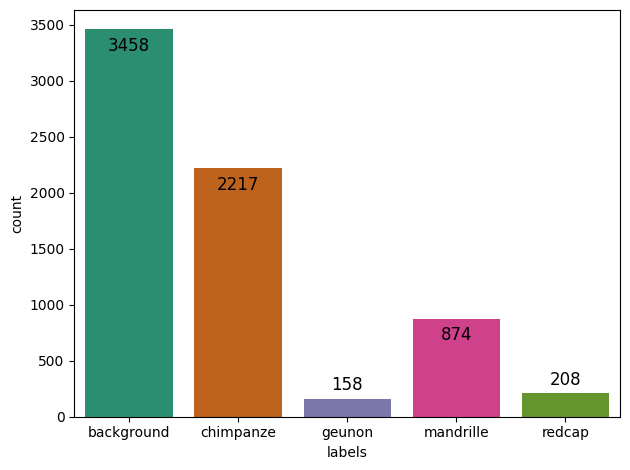

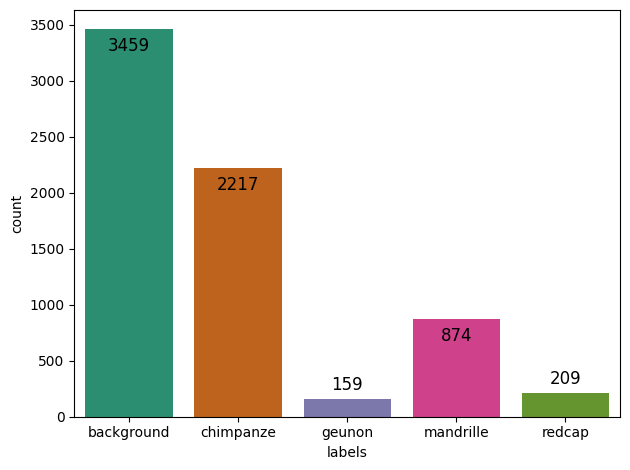

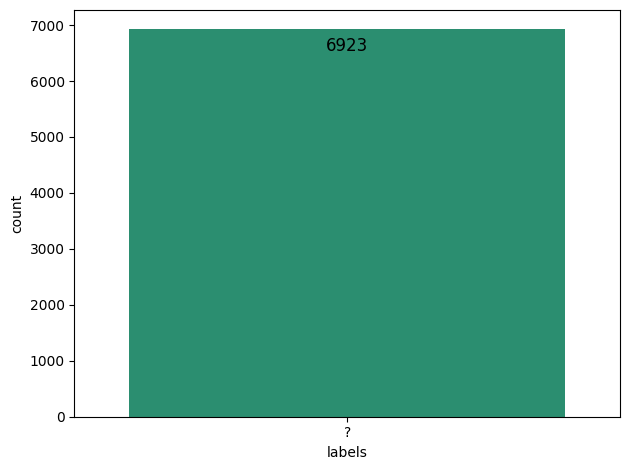

In [32]:
for data_option in data.keys():
    title = 'counts per class'
    # Create the pandas DataFrame
    df = pd.DataFrame().from_dict({key:val for key, val in data[data_option].items() if key!='durations_per_class'})
    # Plotting
    print(df.groupby('labels').count())
    plot = sns.countplot(
        data=df.sort_values('labels'), x='labels',# hue="labels",
        # hue_order=sorted(data[data_option]['durations_per_class'].keys()),

    )
    #plot.set(title=f'{data_option}-dataset {title}')

    for p in plot.patches:
        plot.annotate(format(round(p.get_height()), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       size=12,
                       xytext = (0, (-12) if p.get_height() > 300 else (10)),
                       textcoords = 'offset points')

    show_and_save(data_option, title)


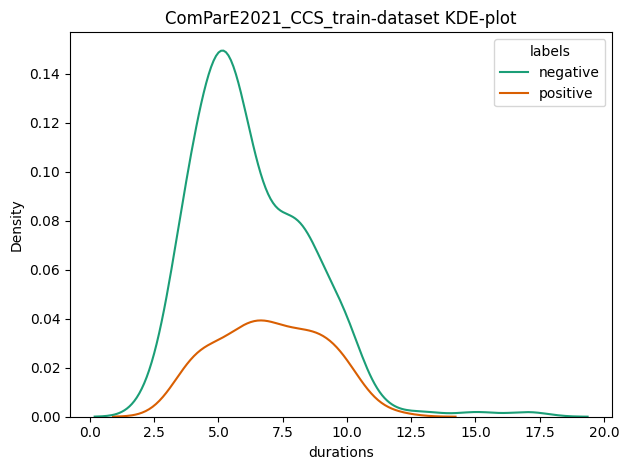

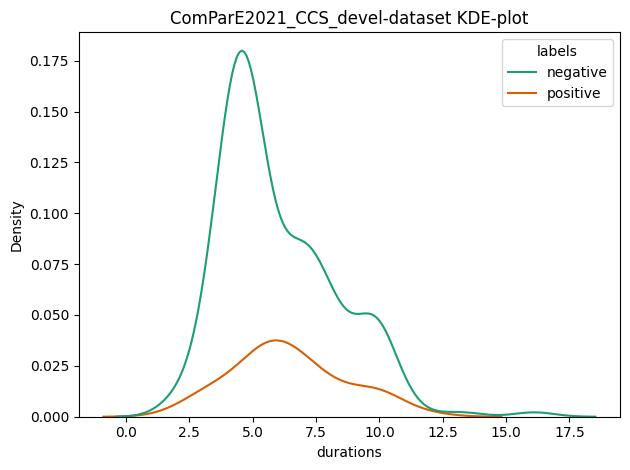

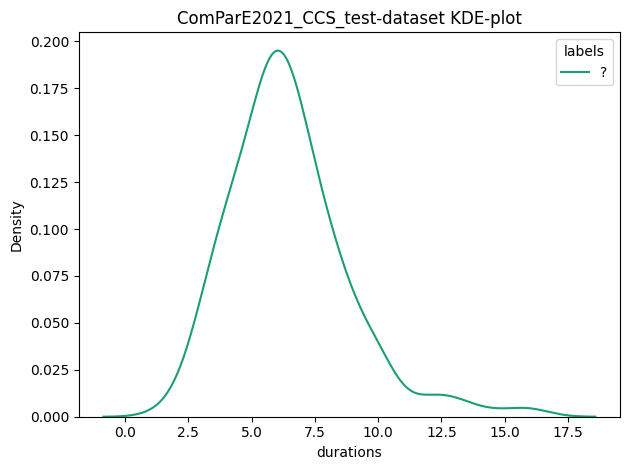

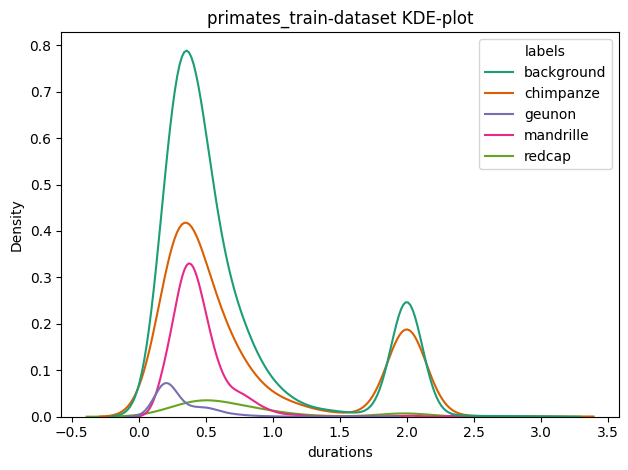

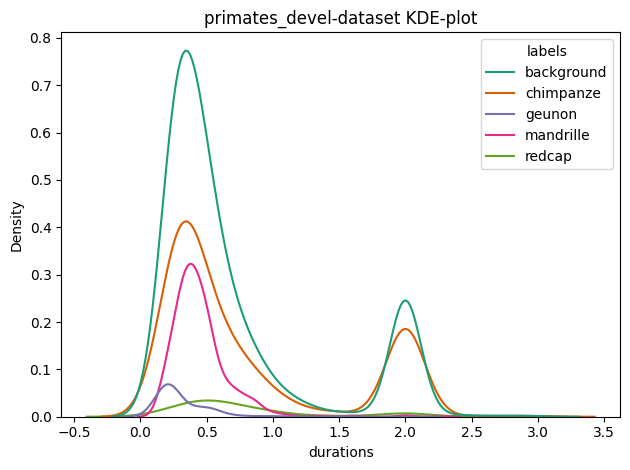

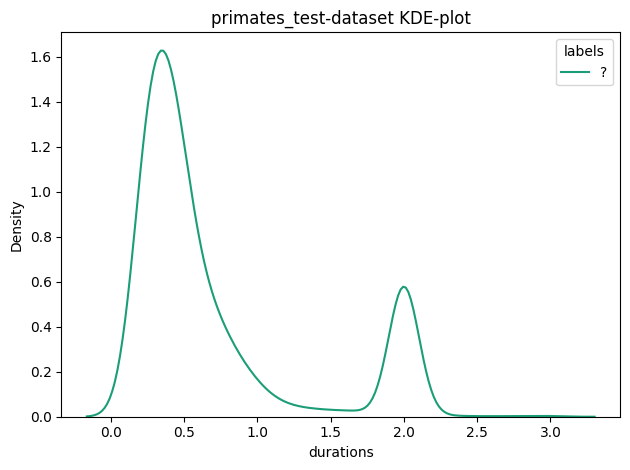

In [14]:
for data_option in data.keys():
    title = f'KDE-plot'
    # Create the pandas DataFrame
    df = pd.DataFrame().from_dict({key:val for key, val in data[data_option].items() if key!='durations_per_class'})
    # Plotting
    kdeplot = sns.kdeplot(
        data=df, x="durations", hue="labels",
        hue_order=sorted(data[data_option]['durations_per_class'].keys()),
        # log_scale=False, element="step", fill=False,
        # cumulative=False, stat="density", common_norm=False,
        # kde=True
    )
    kdeplot.set(title=f'{data_option}-dataset {title}')

    show_and_save(data_option, title)